### Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import shap
from sklearn.feature_selection import mutual_info_regression
pd.set_option('display.max_columns', 500)

### Load Data

In [37]:
energy = pd.read_csv('../../data/energy_dataset.csv')
weather = pd.read_csv('../../data/weather_features.csv')
weather = weather.drop(columns=['weather_id', 'weather_icon']) # remove these columns; they're not informative

### Avg Data Using Josh's Methodology

In [38]:
weather_main_dummies = pd.get_dummies(weather.weather_main)
weather = weather.drop(columns=['weather_main', 'weather_description']).join(weather_main_dummies)

In [39]:
total = pd.DataFrame()

for name in weather.city_name.unique():
    cityData = weather.loc[weather.city_name == name]
    dfn = pd.merge(energy, cityData, left_on='time', right_on='dt_iso')
    dfn=dfn.drop_duplicates("time")
    dfn = dfn.set_index("time")
    if(not(total.empty)):
        total+=dfn
    else:
        total=dfn
    print(total.shape)

(35064, 53)
(35064, 53)
(35064, 53)
(35064, 53)
(35064, 53)


In [40]:
# use idxmax to get the most popular value due to the average (can't really avg categorical value in traditional sense)
total['weather_main'] = total[['clear', 'clouds', 'drizzle', 'dust', 'fog', 'haze',
       'mist', 'rain', 'smoke', 'snow', 'squall', 'thunderstorm']].idxmax(axis=1)
total = total.drop(columns=['clear', 'clouds', 'drizzle', 'dust', 'fog', 'haze',
       'mist', 'rain', 'smoke', 'snow', 'squall', 'thunderstorm'])

# take average
def take_avg(col):
    if col.dtype != object:
        col /= 5
    return col

total = total.apply(take_avg)

In [41]:
# don't need these
total = total.drop(columns=['dt_iso', 'city_name'])

In [42]:
# these are null for every datapoint
total = total.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'])

In [44]:
def parse_hour(item):
    hour = int(item[11:13])
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour <=17:
        return 'day'
    return 'night'
def parse_month(item):
    month = int(item[5:7])
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [46]:
# OHE the weather main column
total = pd.get_dummies(total)

In [51]:
# remove 36 entries that have any null values for total load (we don't lose much (?))
total = total.dropna()

In [53]:
# Feature engineer the time of day and season features
total = total.reset_index()
total['time_of_day'] = total.time.apply(parse_hour)
total['season'] = total.time.apply(parse_month)

In [54]:
# push time back into the index for ease of OHE
total = total.set_index('time')

In [56]:
total = pd.get_dummies(total)

In [59]:
total.head(3)

,index,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main_clear,weather_main_clouds,weather_main_drizzle,weather_main_fog,weather_main_mist,weather_main_rain,weather_main_thunderstorm,time_of_day_day,time_of_day_morning,time_of_day_night,season_fall,season_spring,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,0,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2015-01-01 01:00:00+01:00,1,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2015-01-01 02:00:00+01:00,2,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [64]:
# NOTE: not all of the items I include are used for prediction of price
total.drop(columns=['index']).to_csv("final_baseline_data.csv")

### Predict XGBoost!

In [65]:
# select features for PREDICTING PRICE
feat_cols = ['temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle',
       'weather_main_fog', 'weather_main_mist', 'weather_main_rain',
       'weather_main_thunderstorm', 'time_of_day_day', 'time_of_day_morning',
       'time_of_day_night', 'season_fall', 'season_spring', 'season_summer',
       'season_winter']

feat_cols_more = feat_cols + ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load actual']

### Feature IMportance

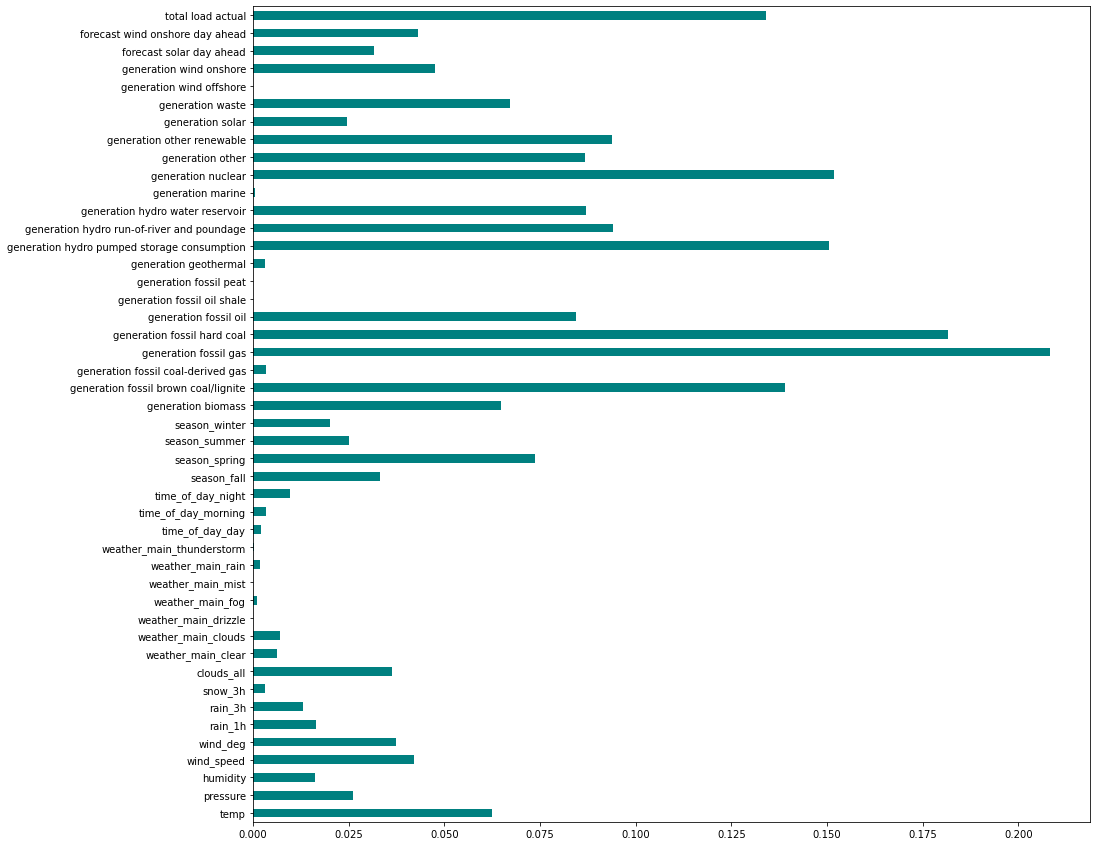

In [67]:
importances = mutual_info_regression(total[feat_cols_more], total['price actual'])
feat_importances = pd.Series(importances, feat_cols_more)
plt.figure(figsize=(15,15))
feat_importances.plot(kind='barh', color='teal')
plt.show()

### Prep Data for Model

In [69]:
import xgboost
from sklearn.model_selection import train_test_split

#note: xgboost doesn't require scaling: https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=There%20are%20some%20algorithms%20like,data%20into%20training%20and%20testing.
from sklearn.preprocessing import MinMaxScaler

In [70]:
subset = total[feat_cols_more + ['price actual']]

In [71]:
training, testing = train_test_split(subset, test_size=0.30)

In [88]:
X_train, y_train = training.to_numpy()[:, :-1], training.to_numpy()[:, -1]
X_test, y_test = testing.to_numpy()[:, :-1], testing.to_numpy()[:, -1]

In [73]:
model_xgb = xgboost.XGBRegressor(random_state=42, max_depth=10, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
model_xgb.feature_importances_

array([0.00542069, 0.00883189, 0.00390007, 0.02663696, 0.00383239,
       0.00625947, 0.00581439, 0.01181947, 0.0055452 , 0.00323348,
       0.00548354, 0.00209201, 0.00089147, 0.00415973, 0.00153338,
       0.        , 0.00614986, 0.00412446, 0.0180299 , 0.05685487,
       0.2802435 , 0.06325825, 0.01971555, 0.00946019, 0.00864508,
       0.        , 0.12950894, 0.04383778, 0.01205671, 0.        ,
       0.        , 0.        , 0.03616619, 0.01858579, 0.02415838,
       0.        , 0.02022036, 0.02068886, 0.04068839, 0.0080432 ,
       0.01779663, 0.        , 0.00761216, 0.01353983, 0.00917123,
       0.03598988], dtype=float32)

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [81]:
y_train_pred = model_xgb.predict(X_train)

In [82]:
mean_squared_error(y_train, y_train_pred)

3.327414834506472

In [83]:
cross_val_score(model_xgb, X_train, y_train)

array([0.88312079, 0.88751522, 0.88664974, 0.89863171, 0.88362629])

In [84]:
r2_score(y_train, y_train_pred)

0.9834683695698909

In [89]:
y_test_pred = model_xgb.predict(X_test)

In [90]:
mean_squared_error(y_test, y_test_pred)

18.78577991727389

In [91]:
cross_val_score(model_xgb, X_test, y_test)

array([0.84124006, 0.82042966, 0.82325814, 0.82652439, 0.84452067])

In [92]:
r2_score(y_test, y_test_pred)

0.9067933423522094